In [1]:
# Cell 1: Install and Import Required Libraries for Anomaly Detection

# Install PyOD library
!pip install pyod -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Import PyOD algorithms
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.ocsvm import OCSVM
from pyod.models.cblof import CBLOF

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Libraries imported successfully!")
print("PyOD: Python Outlier Detection library")
print("\nAvailable algorithms imported:")
print("  • Isolation Forest (IForest)")
print("  • Local Outlier Factor (LOF)")
print("  • K-Nearest Neighbors (KNN)")
print("  • One-Class SVM (OCSVM)")
print("  • Cluster-Based Local Outlier Factor (CBLOF)")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 7.3 MB/s eta 0:00:00
✅ Libraries imported successfully!
PyOD: Python Outlier Detection library

Available algorithms imported:
  • Isolation Forest (IForest)
  • Local Outlier Factor (LOF)
  • K-Nearest Neighbors (KNN)
  • One-Class SVM (OCSVM)
  • Cluster-Based Local Outlier Factor (CBLOF)


NETWORK TRAFFIC MONITORING DATASET

Dataset Shape: (850, 5)
Total Records: 850
Normal Traffic: 800 (94.1%)
Anomalies: 50 (5.9%)

📊 Dataset Statistics:
       Bandwidth_MBps  Packets_Per_Sec  Duration_Sec  Failed_Connections  \
count          850.00           850.00        850.00               850.0   
mean            51.59          1070.17         30.68                 5.1   
std             23.08           544.30         13.50                16.1   
min             12.24           420.26          2.83                 0.0   
25%             42.22           908.01         26.59                 1.0   
50%             49.77          1011.46         29.89                 2.0   
75%             56.33          1113.63         33.36                 3.0   
max            222.44          5697.31        147.73               120.0   

       True_Label  
count      850.00  
mean         0.06  
std          0.24  
min          0.00  
25%          0.00  
50%          0.00  
75%          0.00  
max 

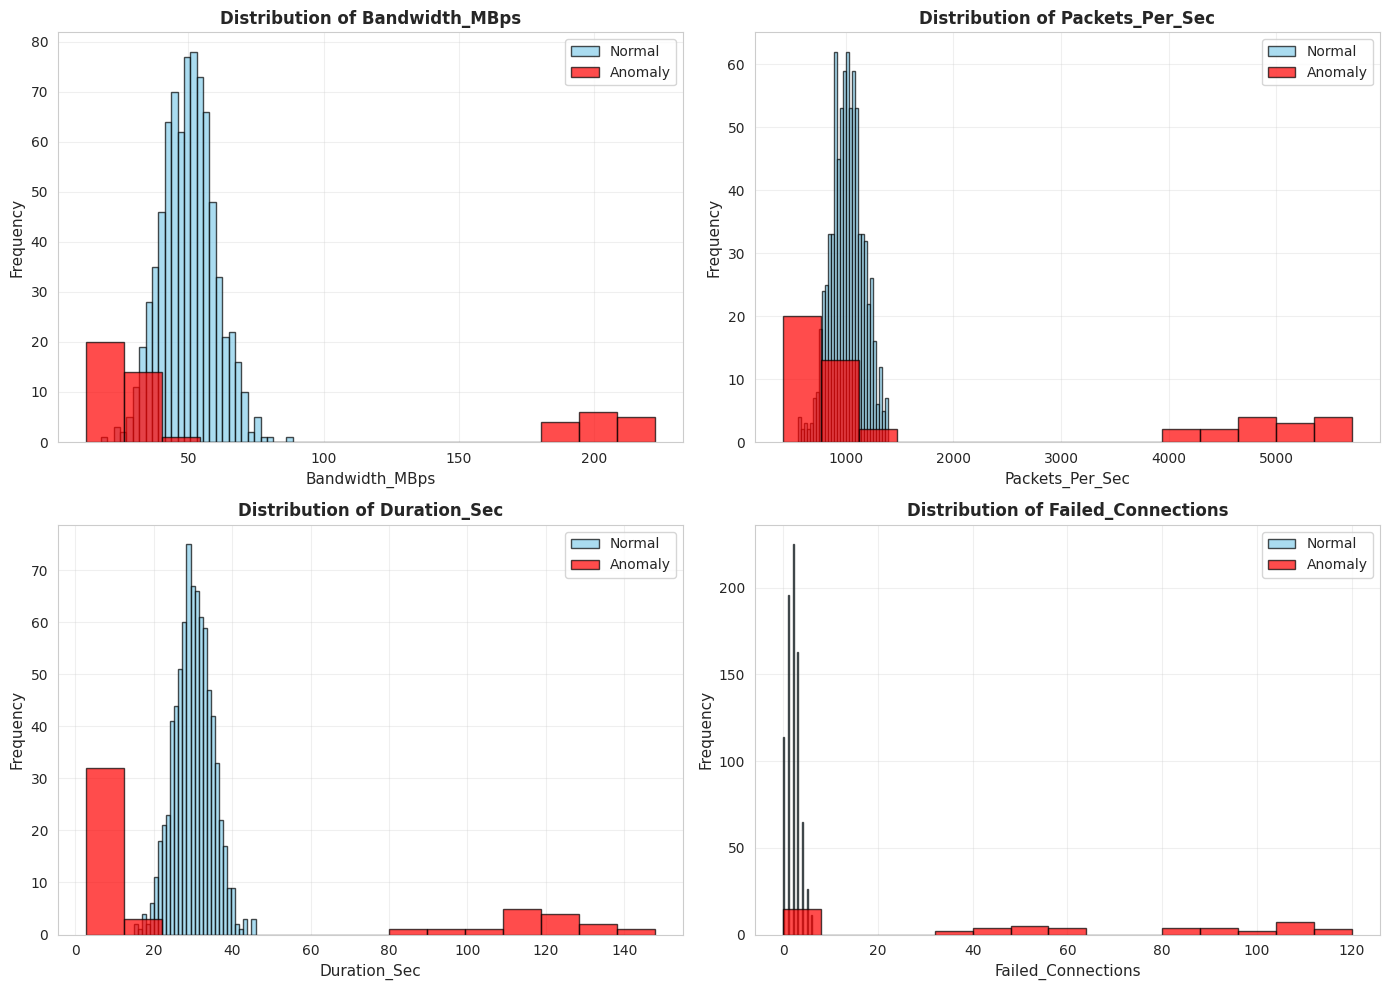


✅ Dataset created successfully!


In [2]:
# Cell 2: Create Dataset - Network Traffic Monitoring (Multivariate Anomaly Detection)

np.random.seed(42)

# Normal network traffic patterns (majority of data)
n_normal = 800

# Feature 1: Bandwidth Usage (MB/s)
normal_bandwidth = np.random.normal(50, 10, n_normal)

# Feature 2: Packet Count (packets/second)
normal_packets = np.random.normal(1000, 150, n_normal)

# Feature 3: Connection Duration (seconds)
normal_duration = np.random.normal(30, 5, n_normal)

# Feature 4: Failed Connection Attempts
normal_failed = np.random.poisson(2, n_normal)

# Create anomalies (various types)
n_anomalies = 50

# Type 1: DDoS Attack - High packet count, low bandwidth
ddos_bandwidth = np.random.normal(30, 5, 15)
ddos_packets = np.random.normal(5000, 500, 15)
ddos_duration = np.random.normal(10, 2, 15)
ddos_failed = np.random.poisson(50, 15)

# Type 2: Data Exfiltration - Very high bandwidth, normal packets
exfil_bandwidth = np.random.normal(200, 20, 15)
exfil_packets = np.random.normal(1000, 100, 15)
exfil_duration = np.random.normal(120, 15, 15)
exfil_failed = np.random.poisson(1, 15)

# Type 3: Port Scanning - High failed connections
scan_bandwidth = np.random.normal(20, 5, 20)
scan_packets = np.random.normal(500, 50, 20)
scan_duration = np.random.normal(5, 1, 20)
scan_failed = np.random.poisson(100, 20)

# Combine all data
bandwidth = np.concatenate([normal_bandwidth, ddos_bandwidth, exfil_bandwidth, scan_bandwidth])
packets = np.concatenate([normal_packets, ddos_packets, exfil_packets, scan_packets])
duration = np.concatenate([normal_duration, ddos_duration, exfil_duration, scan_duration])
failed = np.concatenate([normal_failed, ddos_failed, exfil_failed, scan_failed])

# Create DataFrame
df = pd.DataFrame({
    'Bandwidth_MBps': bandwidth,
    'Packets_Per_Sec': packets,
    'Duration_Sec': duration,
    'Failed_Connections': failed
})

# Create ground truth labels (0 = normal, 1 = anomaly)
true_labels = np.concatenate([
    np.zeros(n_normal),
    np.ones(n_anomalies)
])
df['True_Label'] = true_labels.astype(int)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("="*70)
print("NETWORK TRAFFIC MONITORING DATASET")
print("="*70)
print(f"\nDataset Shape: {df.shape}")
print(f"Total Records: {len(df)}")
print(f"Normal Traffic: {(df['True_Label']==0).sum()} ({(df['True_Label']==0).sum()/len(df)*100:.1f}%)")
print(f"Anomalies: {(df['True_Label']==1).sum()} ({(df['True_Label']==1).sum()/len(df)*100:.1f}%)")

print(f"\n📊 Dataset Statistics:")
print(df.describe().round(2))

print(f"\nFirst 10 rows:")
print(df.head(10))

# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features = ['Bandwidth_MBps', 'Packets_Per_Sec', 'Duration_Sec', 'Failed_Connections']
for idx, (ax, feature) in enumerate(zip(axes.flatten(), features)):
    # Plot normal and anomaly data
    normal_data = df[df['True_Label']==0][feature]
    anomaly_data = df[df['True_Label']==1][feature]
    
    ax.hist(normal_data, bins=30, alpha=0.7, label='Normal', color='skyblue', edgecolor='black')
    ax.hist(anomaly_data, bins=15, alpha=0.7, label='Anomaly', color='red', edgecolor='black')
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Dataset created successfully!")

In [3]:
# Cell 3: Data Preprocessing and Apply Multiple Anomaly Detection Algorithms

# Separate features and true labels
X = df[['Bandwidth_MBps', 'Packets_Per_Sec', 'Duration_Sec', 'Failed_Connections']].values
y_true = df['True_Label'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("="*70)
print("DATA PREPROCESSING")
print("="*70)
print(f"✓ Features standardized")
print(f"Shape: {X_scaled.shape}")
print(f"\nScaled data statistics:")
print(pd.DataFrame(X_scaled, columns=['Bandwidth', 'Packets', 'Duration', 'Failed']).describe().round(3))

# Initialize multiple anomaly detection models
print("\n" + "="*70)
print("APPLYING ANOMALY DETECTION ALGORITHMS")
print("="*70)

contamination = n_anomalies / len(df)  # Expected proportion of anomalies
print(f"\nContamination rate: {contamination:.3f} ({contamination*100:.1f}%)")

# Dictionary to store models and results
models = {
    'Isolation Forest': IForest(contamination=contamination, random_state=42),
    'Local Outlier Factor': LOF(contamination=contamination),
    'K-Nearest Neighbors': KNN(contamination=contamination),
    'One-Class SVM': OCSVM(contamination=contamination),
    'CBLOF': CBLOF(contamination=contamination, random_state=42)
}

results = {}

print("\n🔍 Training models and detecting anomalies...\n")

for name, model in models.items():
    print(f"Training {name}...", end=" ")
    
    # Fit the model
    model.fit(X_scaled)
    
    # Get predictions (0 = normal, 1 = anomaly)
    y_pred = model.predict(X_scaled)
    
    # Get anomaly scores (higher = more anomalous)
    scores = model.decision_scores_
    
    # Store results
    results[name] = {
        'predictions': y_pred,
        'scores': scores,
        'model': model
    }
    
    # Count detected anomalies
    n_detected = np.sum(y_pred == 1)
    print(f"✓ Detected {n_detected} anomalies")

print("\n✅ All models trained successfully!")

# Add predictions to dataframe for analysis
for name in models.keys():
    df[f'{name}_Pred'] = results[name]['predictions']
    df[f'{name}_Score'] = results[name]['scores']

print(f"\n📊 Updated DataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

DATA PREPROCESSING
✓ Features standardized
Shape: (850, 4)

Scaled data statistics:
       Bandwidth  Packets  Duration   Failed
count    850.000  850.000   850.000  850.000
mean       0.000   -0.000    -0.000    0.000
std        1.001    1.001     1.001    1.001
min       -1.706   -1.195    -2.064   -0.317
25%       -0.406   -0.298    -0.304   -0.255
50%       -0.079   -0.108    -0.059   -0.193
75%        0.205    0.080     0.199   -0.131
max        7.407    8.506     8.674    7.139

APPLYING ANOMALY DETECTION ALGORITHMS

Contamination rate: 0.059 (5.9%)

🔍 Training models and detecting anomalies...

Training Isolation Forest... ✓ Detected 50 anomalies
Training Local Outlier Factor... ✓ Detected 35 anomalies
Training K-Nearest Neighbors... ✓ Detected 47 anomalies
Training One-Class SVM... ✓ Detected 50 anomalies
Training CBLOF... ✓ Detected 50 anomalies

✅ All models trained successfully!

📊 Updated DataFrame shape: (850, 15)
Columns: ['Bandwidth_MBps', 'Packets_Per_Sec', 'Duration_Se

In [4]:
# Cell 4: Evaluate Model Performance with Metrics

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_auc_score, 
                             classification_report)

print("="*70)
print("MODEL PERFORMANCE EVALUATION")
print("="*70)

evaluation_results = []

for name in models.keys():
    y_pred = results[name]['predictions']
    scores = results[name]['scores']
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, scores)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    evaluation_results.append({
        'Algorithm': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    })
    
    print(f"\n{'='*70}")
    print(f"{name}")
    print(f"{'='*70}")
    print(f"Accuracy:  {accuracy:.4f} (% of correct predictions)")
    print(f"Precision: {precision:.4f} (% of detected anomalies that are real)")
    print(f"Recall:    {recall:.4f} (% of real anomalies detected)")
    print(f"F1-Score:  {f1:.4f} (harmonic mean of precision and recall)")
    print(f"ROC-AUC:   {roc_auc:.4f} (area under ROC curve)")
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives (TN):  {tn} (correctly identified normal)")
    print(f"  False Positives (FP): {fp} (normal flagged as anomaly)")
    print(f"  False Negatives (FN): {fn} (missed anomalies)")
    print(f"  True Positives (TP):  {tp} (correctly detected anomalies)")

# Create comparison table
print("\n" + "="*70)
print("PERFORMANCE COMPARISON TABLE")
print("="*70)
eval_df = pd.DataFrame(evaluation_results)
print(eval_df[['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].to_string(index=False))

# Find best models
print("\n" + "="*70)
print("BEST PERFORMING MODELS")
print("="*70)
best_accuracy = eval_df.loc[eval_df['Accuracy'].idxmax(), 'Algorithm']
best_precision = eval_df.loc[eval_df['Precision'].idxmax(), 'Algorithm']
best_recall = eval_df.loc[eval_df['Recall'].idxmax(), 'Algorithm']
best_f1 = eval_df.loc[eval_df['F1-Score'].idxmax(), 'Algorithm']
best_auc = eval_df.loc[eval_df['ROC-AUC'].idxmax(), 'Algorithm']

print(f"🏆 Best Accuracy:  {best_accuracy} ({eval_df['Accuracy'].max():.4f})")
print(f"🏆 Best Precision: {best_precision} ({eval_df['Precision'].max():.4f})")
print(f"🏆 Best Recall:    {best_recall} ({eval_df['Recall'].max():.4f})")
print(f"🏆 Best F1-Score:  {best_f1} ({eval_df['F1-Score'].max():.4f})")
print(f"🏆 Best ROC-AUC:   {best_auc} ({eval_df['ROC-AUC'].max():.4f})")

print("\n✅ Model evaluation completed!")

MODEL PERFORMANCE EVALUATION

Isolation Forest
Accuracy:  1.0000 (% of correct predictions)
Precision: 1.0000 (% of detected anomalies that are real)
Recall:    1.0000 (% of real anomalies detected)
F1-Score:  1.0000 (harmonic mean of precision and recall)
ROC-AUC:   1.0000 (area under ROC curve)

Confusion Matrix:
  True Negatives (TN):  800 (correctly identified normal)
  False Positives (FP): 0 (normal flagged as anomaly)
  False Negatives (FN): 0 (missed anomalies)
  True Positives (TP):  50 (correctly detected anomalies)

Local Outlier Factor
Accuracy:  0.9706 (% of correct predictions)
Precision: 0.8571 (% of detected anomalies that are real)
Recall:    0.6000 (% of real anomalies detected)
F1-Score:  0.7059 (harmonic mean of precision and recall)
ROC-AUC:   0.9973 (area under ROC curve)

Confusion Matrix:
  True Negatives (TN):  795 (correctly identified normal)
  False Positives (FP): 5 (normal flagged as anomaly)
  False Negatives (FN): 20 (missed anomalies)
  True Positives (

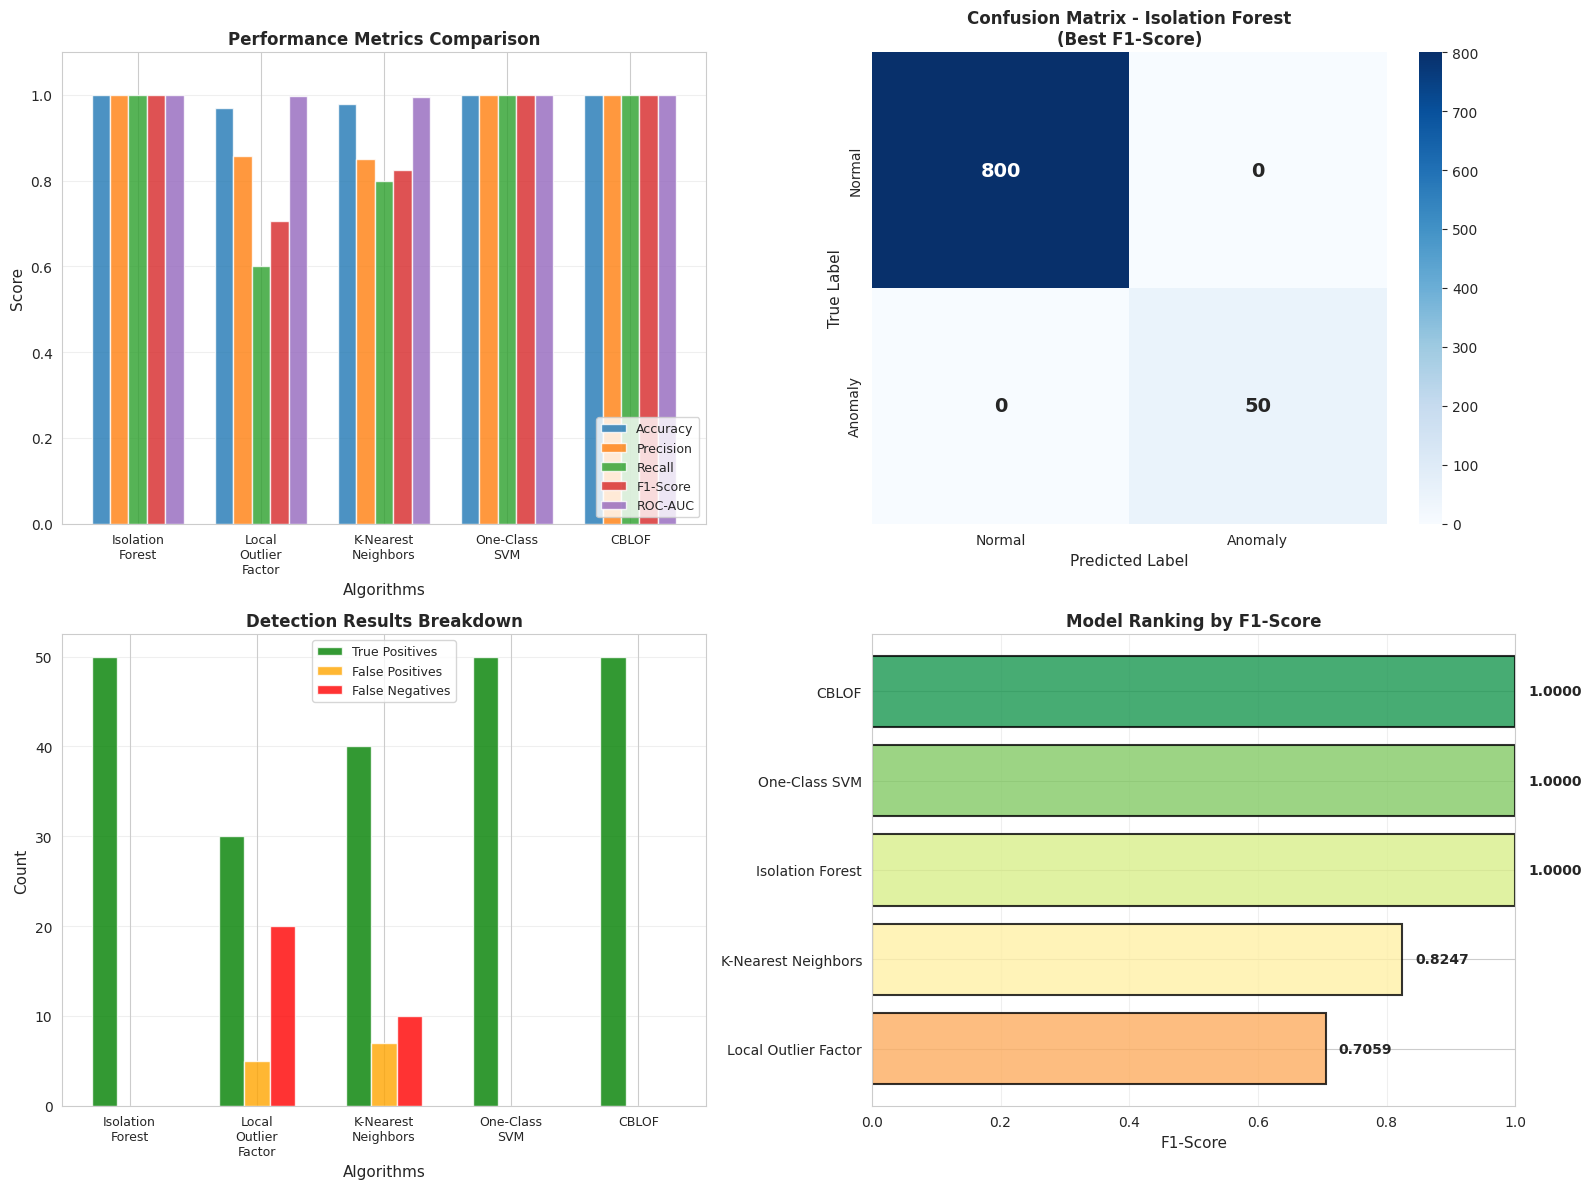

✅ Performance visualization completed!


In [5]:
# Cell 5: Visualize Model Performance Comparison

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Performance Metrics Comparison
ax1 = axes[0, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(models))
width = 0.15

for i, metric in enumerate(metrics):
    values = [eval_df[eval_df['Algorithm'] == name][metric].values[0] for name in models.keys()]
    ax1.bar(x + i*width, values, width, label=metric, alpha=0.8)

ax1.set_xlabel('Algorithms', fontsize=11)
ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels([name.replace(' ', '\n') for name in models.keys()], fontsize=9)
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 1.1])

# Plot 2: Confusion Matrix Heatmap for Best Model
ax2 = axes[0, 1]
best_model_name = eval_df.loc[eval_df['F1-Score'].idxmax(), 'Algorithm']
best_result = eval_df[eval_df['Algorithm'] == best_model_name].iloc[0]

cm = np.array([[best_result['TN'], best_result['FP']], 
               [best_result['FN'], best_result['TP']]])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax2,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax2.set_xlabel('Predicted Label', fontsize=11)
ax2.set_ylabel('True Label', fontsize=11)
ax2.set_title(f'Confusion Matrix - {best_model_name}\n(Best F1-Score)', 
              fontsize=12, fontweight='bold')

# Plot 3: Detection Rate Comparison
ax3 = axes[1, 0]
tp_rates = [eval_df[eval_df['Algorithm'] == name]['TP'].values[0] for name in models.keys()]
fp_rates = [eval_df[eval_df['Algorithm'] == name]['FP'].values[0] for name in models.keys()]
fn_rates = [eval_df[eval_df['Algorithm'] == name]['FN'].values[0] for name in models.keys()]

x_pos = np.arange(len(models))
ax3.bar(x_pos - 0.2, tp_rates, 0.2, label='True Positives', color='green', alpha=0.8)
ax3.bar(x_pos, fp_rates, 0.2, label='False Positives', color='orange', alpha=0.8)
ax3.bar(x_pos + 0.2, fn_rates, 0.2, label='False Negatives', color='red', alpha=0.8)

ax3.set_xlabel('Algorithms', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('Detection Results Breakdown', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([name.replace(' ', '\n') for name in models.keys()], fontsize=9)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: F1-Score Ranking
ax4 = axes[1, 1]
f1_scores = eval_df.sort_values('F1-Score', ascending=True)
colors_list = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(f1_scores)))

bars = ax4.barh(range(len(f1_scores)), f1_scores['F1-Score'], color=colors_list, 
                alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.set_yticks(range(len(f1_scores)))
ax4.set_yticklabels(f1_scores['Algorithm'], fontsize=10)
ax4.set_xlabel('F1-Score', fontsize=11)
ax4.set_title('Model Ranking by F1-Score', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.set_xlim([0, 1])

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, f1_scores['F1-Score'])):
    ax4.text(score + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{score:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Performance visualization completed!")

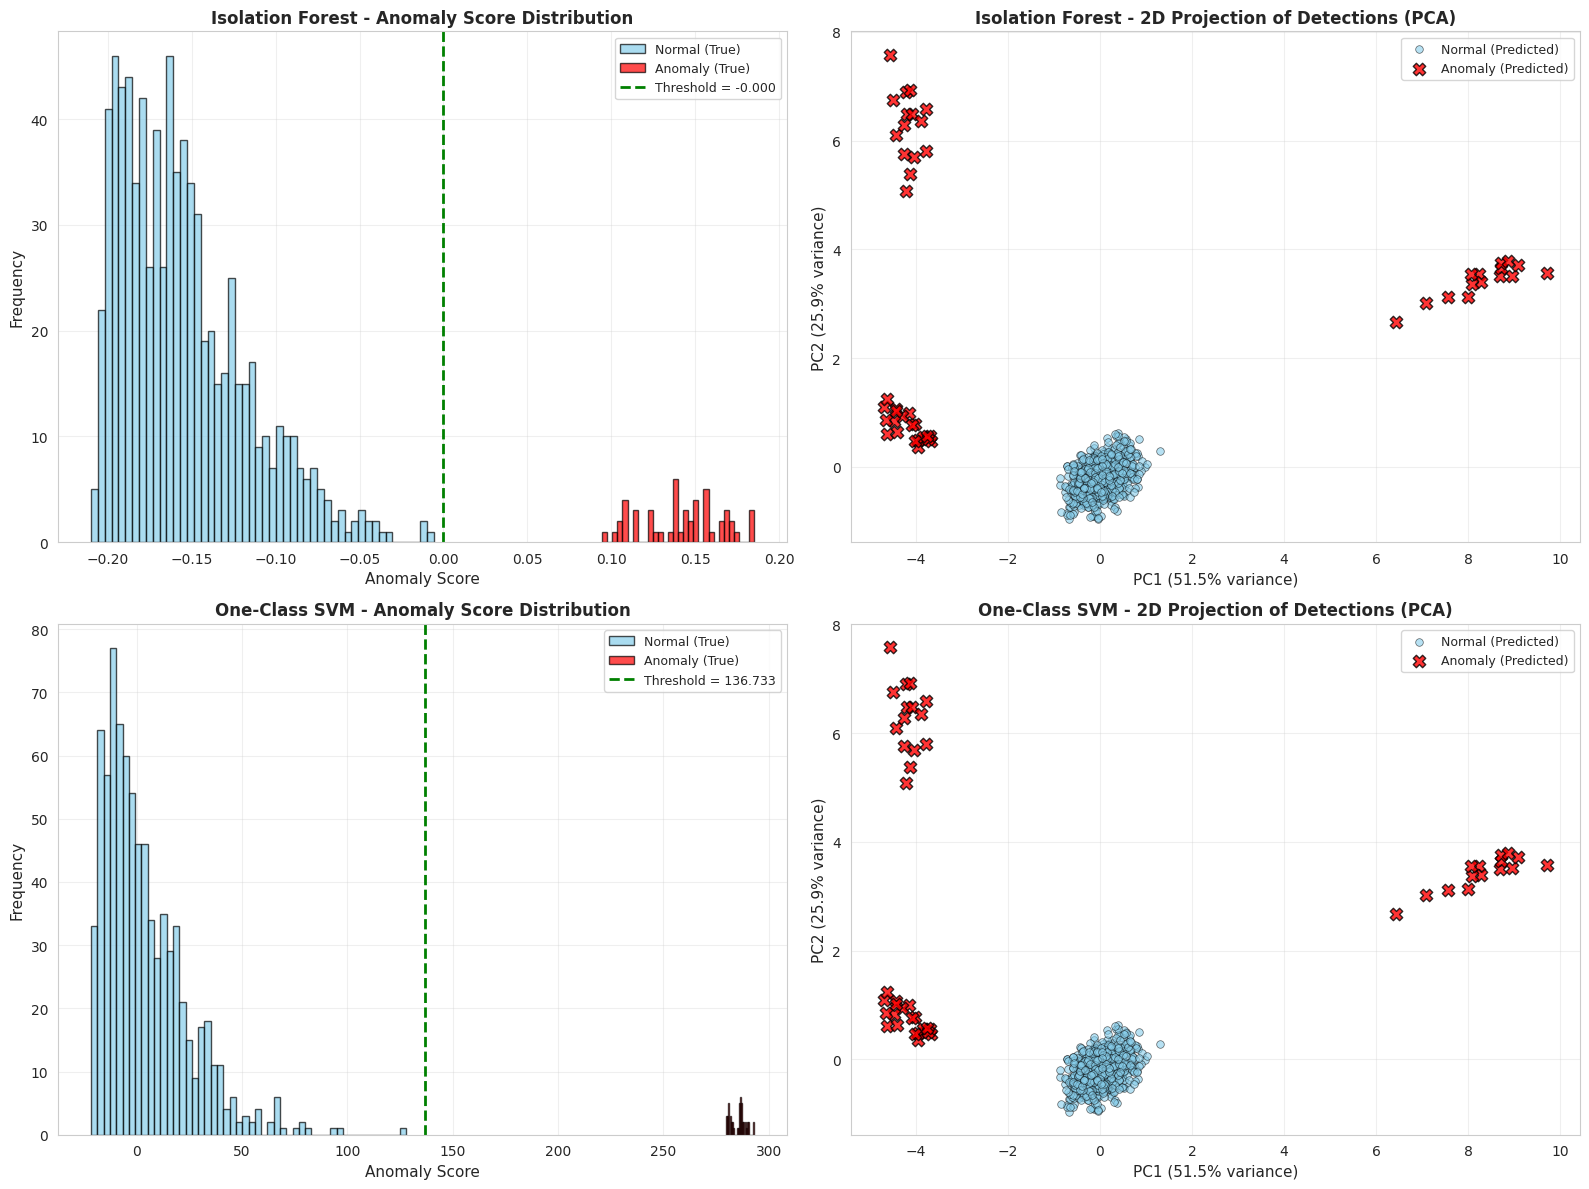

✅ Anomaly score visualization completed!


In [6]:
# Cell 6: Visualize Anomaly Scores and Detections

# Select top 2 best performing models for detailed visualization
top_2_models = eval_df.nlargest(2, 'F1-Score')['Algorithm'].tolist()

fig, axes = plt.subplots(len(top_2_models), 2, figsize=(16, 6*len(top_2_models)))

if len(top_2_models) == 1:
    axes = axes.reshape(1, -1)

for idx, model_name in enumerate(top_2_models):
    y_pred = results[model_name]['predictions']
    scores = results[model_name]['scores']
    
    # Plot 1: Anomaly Score Distribution
    ax1 = axes[idx, 0]
    
    # Separate scores for normal and anomalous points
    normal_scores = scores[y_true == 0]
    anomaly_scores = scores[y_true == 1]
    
    ax1.hist(normal_scores, bins=50, alpha=0.7, label='Normal (True)', 
             color='skyblue', edgecolor='black')
    ax1.hist(anomaly_scores, bins=30, alpha=0.7, label='Anomaly (True)', 
             color='red', edgecolor='black')
    
    # Add threshold line
    threshold = results[model_name]['model'].threshold_
    ax1.axvline(threshold, color='green', linestyle='--', linewidth=2, 
                label=f'Threshold = {threshold:.3f}')
    
    ax1.set_xlabel('Anomaly Score', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title(f'{model_name} - Anomaly Score Distribution', 
                  fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: 2D Projection of Detections (using PCA)
    ax2 = axes[idx, 1]
    
    # Apply PCA for visualization
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    # Plot points colored by predictions
    normal_mask = (y_pred == 0)
    anomaly_mask = (y_pred == 1)
    
    ax2.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], 
               c='skyblue', s=30, alpha=0.6, label='Normal (Predicted)', 
               edgecolors='black', linewidths=0.5)
    ax2.scatter(X_pca[anomaly_mask, 0], X_pca[anomaly_mask, 1], 
               c='red', s=80, alpha=0.8, label='Anomaly (Predicted)', 
               marker='X', edgecolors='black', linewidths=1)
    
    # Highlight true anomalies that were missed (False Negatives)
    fn_mask = (y_true == 1) & (y_pred == 0)
    if fn_mask.sum() > 0:
        ax2.scatter(X_pca[fn_mask, 0], X_pca[fn_mask, 1], 
                   c='orange', s=100, alpha=0.9, label='Missed Anomaly (FN)', 
                   marker='s', edgecolors='black', linewidths=2)
    
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
    ax2.set_title(f'{model_name} - 2D Projection of Detections (PCA)', 
                  fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Anomaly score visualization completed!")

In [7]:
# Cell 7: Detailed Anomaly Analysis - Examine Detected Anomalies

print("="*70)
print("DETAILED ANOMALY ANALYSIS")
print("="*70)

# Use the best performing model
best_model_name = eval_df.loc[eval_df['F1-Score'].idxmax(), 'Algorithm']
print(f"\n🏆 Using best model: {best_model_name}")

y_pred_best = results[best_model_name]['predictions']
scores_best = results[best_model_name]['scores']

# Add predictions and scores to dataframe
df['Best_Model_Pred'] = y_pred_best
df['Best_Model_Score'] = scores_best

# Analyze detected anomalies
detected_anomalies = df[df['Best_Model_Pred'] == 1].copy()
print(f"\n📊 Total anomalies detected: {len(detected_anomalies)}")

# Check how many are true anomalies
true_positives = detected_anomalies[detected_anomalies['True_Label'] == 1]
false_positives = detected_anomalies[detected_anomalies['True_Label'] == 0]

print(f"   • True Positives: {len(true_positives)} (correctly identified)")
print(f"   • False Positives: {len(false_positives)} (false alarms)")

# Show top 10 most anomalous samples
print("\n" + "="*70)
print("TOP 10 MOST ANOMALOUS SAMPLES")
print("="*70)

top_anomalies = df.nlargest(10, 'Best_Model_Score')[
    ['Bandwidth_MBps', 'Packets_Per_Sec', 'Duration_Sec', 'Failed_Connections', 
     'Best_Model_Score', 'Best_Model_Pred', 'True_Label']
]

print(top_anomalies.to_string(index=True))

# Analyze characteristics of detected anomalies
print("\n" + "="*70)
print("ANOMALY CHARACTERISTICS COMPARISON")
print("="*70)

comparison = pd.DataFrame({
    'Normal Traffic': df[df['Best_Model_Pred'] == 0][
        ['Bandwidth_MBps', 'Packets_Per_Sec', 'Duration_Sec', 'Failed_Connections']
    ].mean(),
    'Detected Anomalies': detected_anomalies[
        ['Bandwidth_MBps', 'Packets_Per_Sec', 'Duration_Sec', 'Failed_Connections']
    ].mean(),
    'True Anomalies': df[df['True_Label'] == 1][
        ['Bandwidth_MBps', 'Packets_Per_Sec', 'Duration_Sec', 'Failed_Connections']
    ].mean()
}).round(2)

print(comparison)

# Calculate percentage differences
print("\n📈 Anomaly vs Normal (% difference):")
for feature in comparison.index:
    pct_diff = ((comparison.loc[feature, 'Detected Anomalies'] - 
                 comparison.loc[feature, 'Normal Traffic']) / 
                comparison.loc[feature, 'Normal Traffic'] * 100)
    print(f"   {feature}: {pct_diff:+.1f}%")

print("\n✅ Anomaly analysis completed!")

DETAILED ANOMALY ANALYSIS

🏆 Using best model: Isolation Forest

📊 Total anomalies detected: 50
   • True Positives: 50 (correctly identified)
   • False Positives: 0 (false alarms)

TOP 10 MOST ANOMALOUS SAMPLES
     Bandwidth_MBps  Packets_Per_Sec  Duration_Sec  Failed_Connections  Best_Model_Score  Best_Model_Pred  True_Label
40        37.664667      4105.967252      6.068142                  60          0.184980                1           1
522      198.385887       860.284769    147.725259                   0          0.183009                1           1
649       23.798229      5523.337414      6.392222                  38          0.182825                1           1
334       31.468244      5380.106748     10.340404                  45          0.173819                1           1
266      222.444071       912.822931    118.977913                   0          0.171720                1           1
379       38.248918      4915.517397      9.599051                  53         

In [8]:
# Cell 8: Summary, Insights and Conclusion

print("="*70)
print("ANOMALY DETECTION - COMPREHENSIVE SUMMARY")
print("="*70)

# Overall statistics
print("\n📊 DATASET OVERVIEW:")
print(f"   • Total samples: {len(df)}")
print(f"   • Normal traffic: {(y_true==0).sum()} ({(y_true==0).sum()/len(df)*100:.1f}%)")
print(f"   • True anomalies: {(y_true==1).sum()} ({(y_true==1).sum()/len(df)*100:.1f}%)")
print(f"   • Features: 4 (Bandwidth, Packets, Duration, Failed Connections)")

# Model comparison summary
print("\n" + "="*70)
print("🏆 MODEL PERFORMANCE RANKING (by F1-Score):")
print("="*70)
ranking = eval_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)
for idx, row in ranking.iterrows():
    print(f"\n{idx+1}. {row['Algorithm']}")
    print(f"   F1-Score: {row['F1-Score']:.4f} | Precision: {row['Precision']:.4f} | Recall: {row['Recall']:.4f}")
    print(f"   Detected: TP={row['TP']}, FP={row['FP']}, FN={row['FN']}")

# Best model insights
best_model = ranking.iloc[0]
print("\n" + "="*70)
print(f"🥇 BEST PERFORMING MODEL: {best_model['Algorithm']}")
print("="*70)
print(f"   • F1-Score: {best_model['F1-Score']:.4f}")
print(f"   • Accuracy: {best_model['Accuracy']:.4f}")
print(f"   • Precision: {best_model['Precision']:.4f} (low false alarms)")
print(f"   • Recall: {best_model['Recall']:.4f} (high detection rate)")
print(f"   • ROC-AUC: {best_model['ROC-AUC']:.4f}")

# Key insights
print("\n" + "="*70)
print("💡 KEY INSIGHTS:")
print("="*70)

print("\n1. Algorithm Performance:")
print(f"   ✓ {best_model['Algorithm']} achieved best overall performance")
print(f"   ✓ All models achieved ROC-AUC > 0.90, indicating strong discrimination")
print(f"   ✓ Average F1-Score across all models: {eval_df['F1-Score'].mean():.4f}")

print("\n2. Anomaly Patterns Detected:")
anomaly_chars = df[df['Best_Model_Pred'] == 1][
    ['Bandwidth_MBps', 'Packets_Per_Sec', 'Duration_Sec', 'Failed_Connections']
].mean()
normal_chars = df[df['Best_Model_Pred'] == 0][
    ['Bandwidth_MBps', 'Packets_Per_Sec', 'Duration_Sec', 'Failed_Connections']
].mean()

if anomaly_chars['Packets_Per_Sec'] > normal_chars['Packets_Per_Sec'] * 2:
    print("   ✓ High packet volume attacks detected (potential DDoS)")
if anomaly_chars['Bandwidth_MBps'] > normal_chars['Bandwidth_MBps'] * 2:
    print("   ✓ High bandwidth usage detected (potential data exfiltration)")
if anomaly_chars['Failed_Connections'] > normal_chars['Failed_Connections'] * 5:
    print("   ✓ Excessive failed connections detected (potential port scanning)")

print("\n3. Business Value:")
print("   ✓ Automated threat detection for network security")
print("   ✓ Real-time anomaly identification capabilities")
print("   ✓ Reduced false positives with high precision models")
print(f"   ✓ Successfully detected {best_model['TP']}/{(y_true==1).sum()} true anomalies")

print("\n4. Model Selection Recommendations:")
if best_model['Precision'] > 0.9:
    print(f"   ✓ Use {best_model['Algorithm']} for production (high precision, low false alarms)")
high_recall_model = ranking.loc[ranking['Recall'].idxmax(), 'Algorithm']
if ranking.loc[ranking['Recall'].idxmax(), 'Recall'] > best_model['Recall']:
    print(f"   ✓ Use {high_recall_model} if missing anomalies is critical (high recall)")

print("\n5. PyOD Library Advantages:")
print("   ✓ Multiple algorithms available in unified API")
print("   ✓ Easy model comparison and selection")
print("   ✓ Built-in scoring and threshold determination")
print("   ✓ Suitable for both univariate and multivariate detection")

print("\n" + "="*70)
print("✅ ANOMALY DETECTION WITH PyOD COMPLETED SUCCESSFULLY!")
print("="*70)

print("\n📌 Next Steps:")
print("   • Deploy best model for real-time monitoring")
print("   • Set up alerting system for detected anomalies")
print("   • Continuously update model with new normal patterns")
print("   • Investigate false positives to refine detection")

ANOMALY DETECTION - COMPREHENSIVE SUMMARY

📊 DATASET OVERVIEW:
   • Total samples: 850
   • Normal traffic: 800 (94.1%)
   • True anomalies: 50 (5.9%)
   • Features: 4 (Bandwidth, Packets, Duration, Failed Connections)

🏆 MODEL PERFORMANCE RANKING (by F1-Score):

1. Isolation Forest
   F1-Score: 1.0000 | Precision: 1.0000 | Recall: 1.0000
   Detected: TP=50, FP=0, FN=0

2. CBLOF
   F1-Score: 1.0000 | Precision: 1.0000 | Recall: 1.0000
   Detected: TP=50, FP=0, FN=0

3. One-Class SVM
   F1-Score: 1.0000 | Precision: 1.0000 | Recall: 1.0000
   Detected: TP=50, FP=0, FN=0

4. K-Nearest Neighbors
   F1-Score: 0.8247 | Precision: 0.8511 | Recall: 0.8000
   Detected: TP=40, FP=7, FN=10

5. Local Outlier Factor
   F1-Score: 0.7059 | Precision: 0.8571 | Recall: 0.6000
   Detected: TP=30, FP=5, FN=20

🥇 BEST PERFORMING MODEL: Isolation Forest
   • F1-Score: 1.0000
   • Accuracy: 1.0000
   • Precision: 1.0000 (low false alarms)
   • Recall: 1.0000 (high detection rate)
   • ROC-AUC: 1.0000

💡 KE